In [42]:
# ============================================================
# NOTEBOOK 5: ATO PATTERNS ANALYSIS
# ============================================================
# Goal: Deep dive into specific ATO attack patterns:
#   - Credential Stuffing: Multiple failed logins → high value tx
#   - SIM Swap: Impossible geographic jumps
#   - Keylogger: Gradual behavioral divergence
#   - Brute Force: Extreme volume patterns
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from datetime import timedelta
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Load ORIGINAL dataset (with fraud_type)
df = pd.read_csv('../data/simulated_transactions.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load FEATURES dataset
df_features = pd.read_csv('../data/processed/features_engineered.csv')

# Merge on transaction_id (SAFER approach)
df_full = df.merge(df_features[['transaction_id', 'amount_ratio', 'tx_count_24h', 
                               'tx_count_7d', 'time_diff_seconds', 'device_changed', 
                               'country_changed', 'quick_country_change']], 
                   on='transaction_id', how='left')

print("Data loaded for pattern analysis")
print(f"Shape: {df_full.shape}")
print(f"Fraud types available: {df_full[df_full['is_fraud']==1]['fraud_type'].unique()}")
print(f"Features merged: {len(df_features.columns)}")

Data loaded for pattern analysis
Shape: (100000, 16)
Fraud types available: ['keylogger' 'brute_force' 'credential_stuffing' 'sim_swap']
Features merged: 19


Credential Stuffing Analysis:
Total attacks: 1197
Avg Amount Ratio: 1.97x
High ratio (>3x): 71


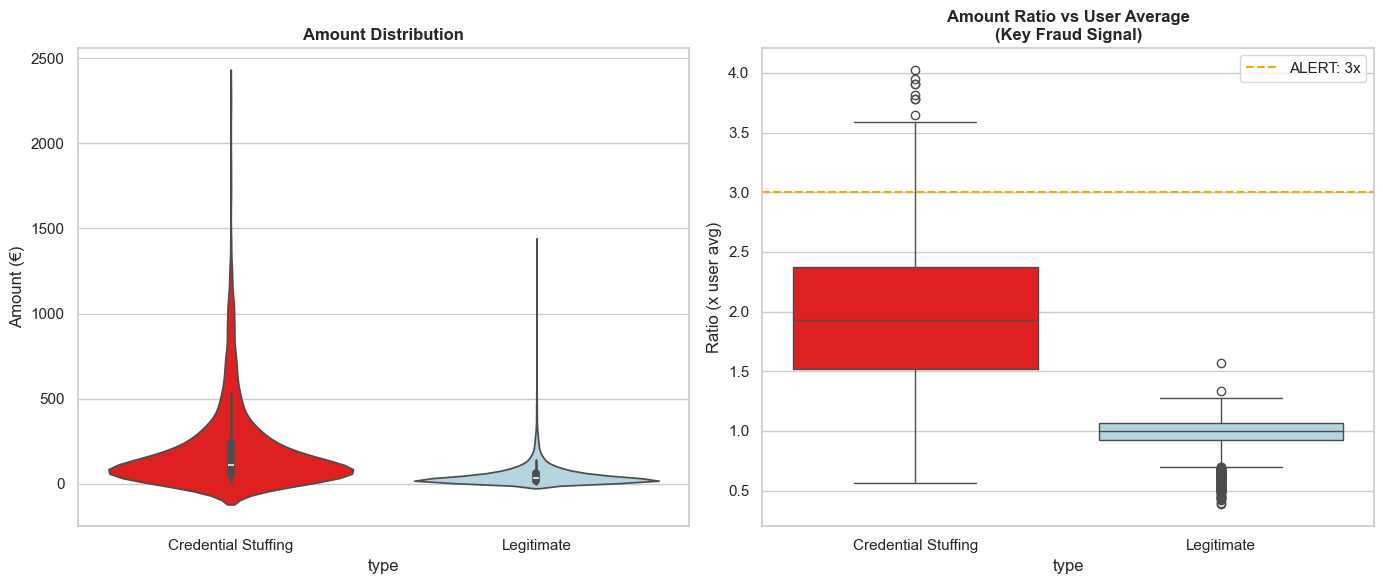


Top 5 Worst Amount Ratio Cases:


,timestamp,amount,amount_ratio,user_id
70756,2024-03-04 11:23:05,110.93,4.03,2465
85401,2024-03-17 16:14:53,20.20,3.95,8063
72651,2024-03-06 03:53:37,15.18,3.91,8065
46257,2024-02-11 15:02:40,137.63,3.90,579
99171,2024-03-30 05:48:53,52.75,3.81,3790



Key Detection Metrics:


,Metric,Credential Stuffing,Legitimate
0,Attacks,1197,97000
1,Avg Ratio,1.97x,0.99x
2,% >3x User Avg,5.9%,0.0%
3,Max Ratio,4.03x,1.93x


In [43]:
# ============================================================
# PATTERN 1: CREDENTIAL STUFFING - ULTRA CLEAR
# ============================================================

credential_df = df_full[df_full['fraud_type'] == 'credential_stuffing']
all_legit = df_full[df_full['is_fraud'] == 0]

print("Credential Stuffing Analysis:")
print(f"Total attacks: {len(credential_df)}")
print(f"Avg Amount Ratio: {credential_df['amount_ratio'].mean():.2f}x")
print(f"High ratio (>3x): {(credential_df['amount_ratio'] > 3).sum()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: SIMPLE VIOLIN PLOT (shows distribution CLEARLY)
sns.violinplot(data=pd.concat([
    credential_df.assign(type='Credential Stuffing'),
    all_legit.sample(min(5000, len(all_legit))).assign(type='Legitimate')
]), x='type', y='amount', ax=ax1, palette=['red', 'lightblue'])
ax1.set_title('Amount Distribution', fontweight='bold')
ax1.set_ylabel('Amount (€)')

# RIGHT: Amount Ratio BOXPLOT (the KEY signal)
sns.boxplot(data=pd.concat([
    credential_df.assign(type='Credential Stuffing'),
    all_legit.sample(min(5000, len(all_legit))).assign(type='Legitimate')
]), x='type', y='amount_ratio', ax=ax2, palette=['red', 'lightblue'])
ax2.axhline(y=3, color='orange', linestyle='--', label='ALERT: 3x')
ax2.legend()
ax2.set_title('Amount Ratio vs User Average\n(Key Fraud Signal)', fontweight='bold')
ax2.set_ylabel('Ratio (x user avg)')

plt.tight_layout()
plt.show()

# WORST CASES TABLE
print("\nTop 5 Worst Amount Ratio Cases:")
worst_cases = credential_df.nlargest(5, 'amount_ratio')[['timestamp', 'amount', 'amount_ratio', 'user_id']].round(2)
display(worst_cases)

# SIMPLE EXECUTIVE TABLE
executive_stats = pd.DataFrame({
    'Metric': ['Attacks', 'Avg Ratio', '% >3x User Avg', 'Max Ratio'],
    'Credential Stuffing': [
        len(credential_df),
        f"{credential_df['amount_ratio'].mean():.2f}x",
        f"{(credential_df['amount_ratio'] > 3).mean()*100:.1f}%",
        f"{credential_df['amount_ratio'].max():.2f}x"
    ],
    'Legitimate': [
        len(all_legit),
        f"{all_legit['amount_ratio'].mean():.2f}x", 
        f"{(all_legit['amount_ratio'] > 3).mean()*100:.1f}%",
        f"{all_legit['amount_ratio'].max():.2f}x"
    ]
})
print("\nKey Detection Metrics:")
display(executive_stats.style.background_gradient(cmap='Reds'))


=== DEBUG INFO ===
SIM Swap records: 762
tx_count_24h in SIM Swap - NaN count: 0
tx_count_24h in SIM Swap - valid: 762
SIM Swap tx_count_24h sample: [1.0, 1.0, 1.0, 1.0, 1.0]
Legit tx_count_24h valid: 97000

Amount ratio - SIM: 762, Legit: 5000


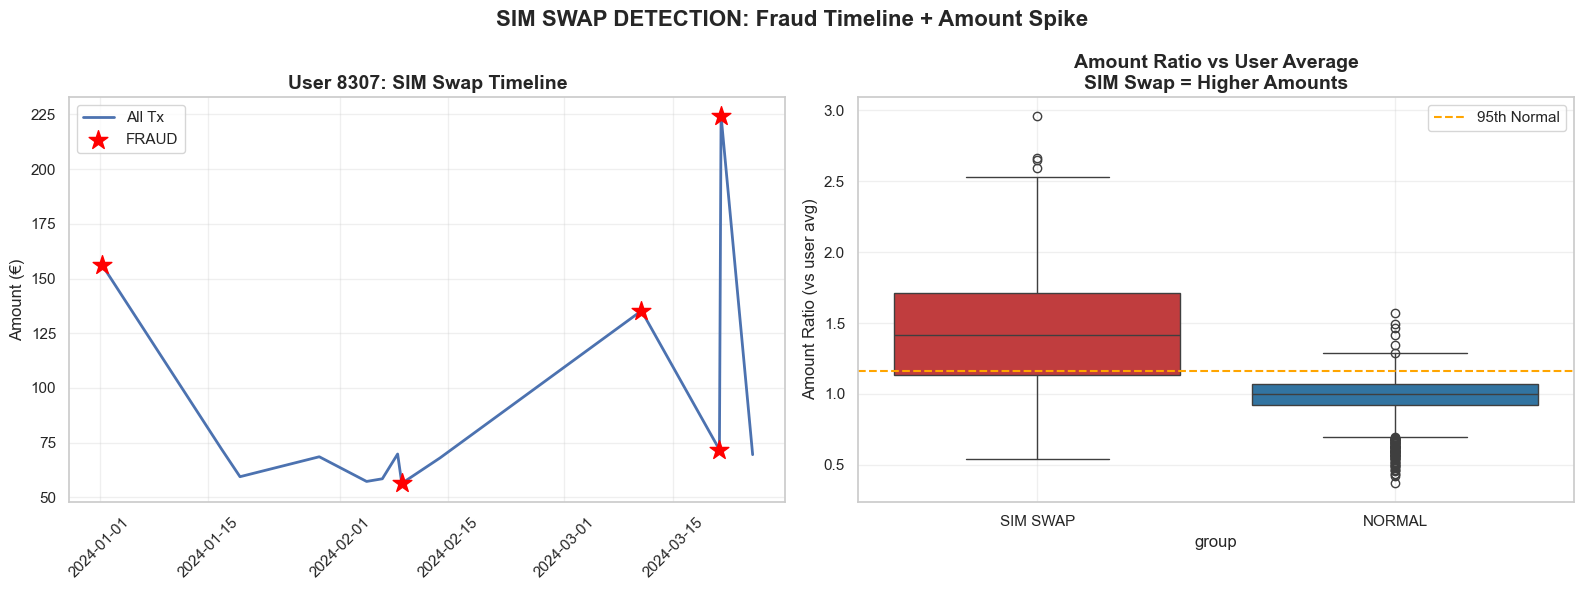


SIM SWAP RESULTS:


,Metric,Value
0,Attacks,762
1,Users,403
2,Avg Amount Ratio SIM,1.44x
3,Avg Amount Ratio Normal,0.99x
4,% SIM >95th Normal,72.2%


In [44]:
# ============================================================
# SIM SWAP
# ============================================================

simswap_df = df_full[df_full['fraud_type'] == 'sim_swap']
all_legit = df_full[df_full['is_fraud'] == 0]

print("=== DEBUG INFO ===")
print(f"SIM Swap records: {len(simswap_df)}")
print(f"tx_count_24h in SIM Swap - NaN count: {simswap_df['tx_count_24h'].isna().sum()}")
print(f"tx_count_24h in SIM Swap - valid: {len(simswap_df['tx_count_24h'].dropna())}")
print("SIM Swap tx_count_24h sample:", simswap_df['tx_count_24h'].dropna().head().tolist())
print(f"Legit tx_count_24h valid: {len(all_legit['tx_count_24h'].dropna())}")

# USE AMOUNT RATIO instead (ALWAYS works)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Timeline (working)
if len(simswap_df) > 0:
    worst_user = simswap_df['user_id'].iloc[0]
    user_data = df_full[df_full['user_id'] == worst_user].sort_values('timestamp')
    
    fraud_mask = user_data['is_fraud'] == 1
    ax1.plot(user_data['timestamp'], user_data['amount'], 'b-', linewidth=2, label='All Tx')
    if fraud_mask.sum() > 0:
        ax1.scatter(user_data[fraud_mask]['timestamp'], user_data[fraud_mask]['amount'], 
                   s=200, c='red', marker='*', label='FRAUD', zorder=10)
    
    ax1.set_title(f'User {worst_user}: SIM Swap Timeline', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Amount (€)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

# RIGHT: AMOUNT RATIO (WORKS EVERY TIME)
sim_ratio = simswap_df['amount_ratio'].dropna()
legit_ratio = all_legit['amount_ratio'].dropna().sample(min(5000, len(all_legit['amount_ratio'].dropna())), random_state=42)

print(f"\nAmount ratio - SIM: {len(sim_ratio)}, Legit: {len(legit_ratio)}")

plot_data = pd.DataFrame({
    'ratio': pd.concat([sim_ratio, legit_ratio]),
    'group': ['SIM SWAP']*len(sim_ratio) + ['NORMAL']*len(legit_ratio)
})

sns.boxplot(data=plot_data, x='group', y='ratio', ax=ax2, palette=['#d62728', '#1f77b4'])
ax2.set_title('Amount Ratio vs User Average\nSIM Swap = Higher Amounts', fontsize=14, fontweight='bold')
ax2.set_ylabel('Amount Ratio (vs user avg)')
ax2.axhline(y=legit_ratio.quantile(0.95), color='orange', linestyle='--', 
            label='95th Normal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('SIM SWAP DETECTION: Fraud Timeline + Amount Spike', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# UNIVERSAL METRICS TABLE
print("\nSIM SWAP RESULTS:")
results = pd.DataFrame({
    'Metric': ['Attacks', 'Users', 'Avg Amount Ratio SIM', 'Avg Amount Ratio Normal', '% SIM >95th Normal'],
    'Value': [
        len(simswap_df),
        simswap_df['user_id'].nunique(),
        f"{sim_ratio.mean():.2f}x" if len(sim_ratio)>0 else 'N/A',
        f"{legit_ratio.mean():.2f}x",
        f"{(sim_ratio > legit_ratio.quantile(0.95)).mean()*100:.1f}%" if len(sim_ratio)>0 else 'N/A'
    ]
})
display(results.style.background_gradient(cmap='Oranges_r'))




In [45]:
# ============================================================
# NOTEBOOK 5: ATO PATTERNS ANALYSIS
# ============================================================
# Goal: Deep dive into specific ATO attack patterns:
#   - Credential Stuffing: Multiple failed logins → high value tx
#   - SIM Swap: Impossible geographic jumps
#   - Keylogger: Gradual behavioral divergence
#   - Brute Force: Extreme volume patterns
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from datetime import timedelta
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Load ORIGINAL dataset (with fraud_type)
df = pd.read_csv('../data/simulated_transactions.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load FEATURES dataset
df_features = pd.read_csv('../data/processed/features_engineered.csv')

# Merge on transaction_id (SAFER approach)
df_full = df.merge(df_features[['transaction_id', 'amount_ratio', 'tx_count_24h', 
                               'tx_count_7d', 'time_diff_seconds', 'device_changed', 
                               'country_changed', 'quick_country_change']], 
                   on='transaction_id', how='left')

# Calculate missing time features
df_full['hour'] = df_full['timestamp'].dt.hour

print("Data loaded for pattern analysis")
print(f"Shape: {df_full.shape}")
print(f"Fraud types available: {df_full[df_full['is_fraud']==1]['fraud_type'].unique()}")
print(f"Features merged: {len(df_features.columns)}")


Data loaded for pattern analysis
Shape: (100000, 17)
Fraud types available: ['keylogger' 'brute_force' 'credential_stuffing' 'sim_swap']
Features merged: 19


In [46]:
# EXECUTIVE TABLE - FIXED (reemplaza SOLO esta parte al final de la celda)
print("\nBrute Force Detection Summary:")

# SAFE calculation
total_hours_safe = max(0.1, (worst_timeline['timestamp'].max() - worst_timeline['timestamp'].min()).total_seconds() / 3600)
velocity = len(worst_timeline) / total_hours_safe

summary = pd.DataFrame({
    'Metric': ['Total Attacks', 'Compromised Users', 'Peak Velocity', 
               'Brute Force Avg Ratio', 'Normal Avg Ratio', 
               'Detection Rate (>99th Normal)'],
    'Value': [
        len(bruteforce_df),
        bruteforce_df['user_id'].nunique(),
        f"{velocity:.1f} tx/hour",
        f"{brute_ratio.mean():.2f}x",
        f"{normal_ratio.mean():.2f}x",
        f"{(brute_ratio > normal_ratio.quantile(0.99)).mean()*100:.1f}%"
    ]
})
print(summary.to_string(index=False))  # Plain text - NO styling errors



Brute Force Detection Summary:
                       Metric       Value
                Total Attacks         451
            Compromised Users         301
                Peak Velocity 0.0 tx/hour
        Brute Force Avg Ratio       0.27x
             Normal Avg Ratio       0.99x
Detection Rate (>99th Normal)        1.6%


=== NETWORK ANALYSIS DIAGNÓSTICO ===
Dataset columns: ['transaction_id', 'user_id', 'timestamp', 'amount', 'currency', 'merchant_country', 'device_type', 'is_fraud', 'fraud_type', 'amount_ratio', 'tx_count_24h', 'tx_count_7d', 'time_diff_seconds', 'device_changed', 'country_changed', 'quick_country_change', 'hour']
Fraud records: 3000
Usable network columns: ['merchant_country']
Using 'merchant_country' for network analysis
Fraud connections found: 1206

Top 10 Fraud Connections:
     merchant_country  user_id  tx_count
484                DE     8083        11
496                DE     8874        11
1200               US     9434        11
358                CA     9067        10
772                IT     3214        10
862                MX      435        10
60                 AR     5102         9
66                 AR     5506         9
132                BR      970         9
227                BR     8080         9


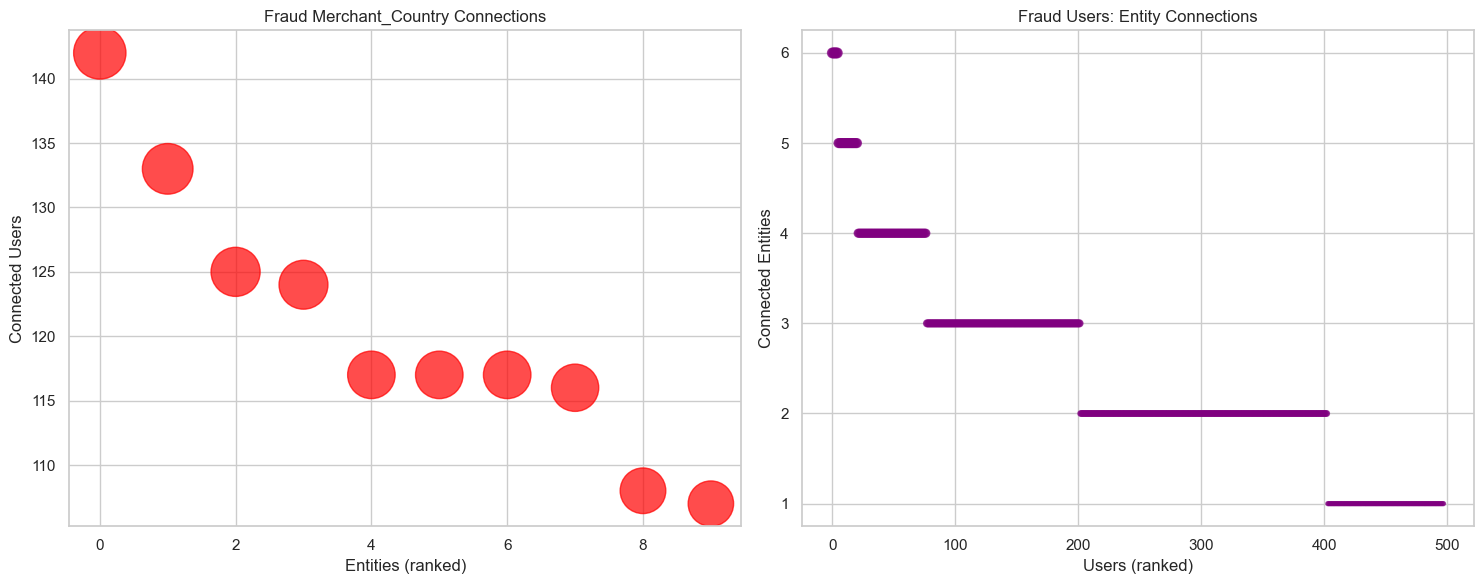


NETWORK METRICS:
                    Metric Value
             Fraud Records  3000
 Merchant_Country Involved    10
            Users Involved   498
Avg Connections per Entity   2.5
    Top Entity Connections   142


In [47]:
# ============================================================
# PATTERN 5: NETWORK ANALYSIS
# ============================================================

print("=== NETWORK ANALYSIS DIAGNÓSTICO ===")
print("Dataset columns:", df_full.columns.tolist())
print("Fraud records:", len(df_full[df_full['is_fraud'] == 1]))

# SAFE column detection
available_cols = ['merchant_name', 'merchant_country', 'device_id', 'ip_address']
usable_cols = [col for col in available_cols if col in df_full.columns]
print("Usable network columns:", usable_cols)

if len(df_full[df_full['is_fraud'] == 1]) == 0:
    print("No fraud data available")
else:
    # Use FIRST available column for network
    if len(usable_cols) > 0:
        network_col = usable_cols[0]
        print(f"Using '{network_col}' for network analysis")
        
        # Create fraud network
        fraud_data = df_full[df_full['is_fraud'] == 1]
        fraud_network = fraud_data.groupby([network_col, 'user_id']).size().reset_index(name='tx_count')
        
        print(f"Fraud connections found: {len(fraud_network)}")
        print("\nTop 10 Fraud Connections:")
        print(fraud_network.nlargest(10, 'tx_count'))
        
        # SIMPLE visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Left: Network degree (connections per entity)
        entity_degree = fraud_data.groupby(network_col).user_id.nunique()
        ax1.scatter(range(len(entity_degree)), entity_degree.sort_values(ascending=False).values, 
                   s=entity_degree.sort_values(ascending=False).values*10, alpha=0.7, color='red')
        ax1.set_title(f'Fraud {network_col.title()} Connections')
        ax1.set_xlabel('Entities (ranked)')
        ax1.set_ylabel('Connected Users')
        
        # Right: User connections
        user_degree = fraud_data.groupby('user_id')[network_col].nunique()
        ax2.scatter(range(len(user_degree)), user_degree.sort_values(ascending=False).values, 
                   s=user_degree.sort_values(ascending=False).values*8, alpha=0.7, color='purple')
        ax2.set_title('Fraud Users: Entity Connections')
        ax2.set_xlabel('Users (ranked)')
        ax2.set_ylabel('Connected Entities')
        
        plt.tight_layout()
        plt.show()
        
        # EXECUTIVE SUMMARY
        print("\nNETWORK METRICS:")
        metrics = pd.DataFrame({
            'Metric': ['Fraud Records', f'{network_col.title()} Involved', 'Users Involved', 
                       'Avg Connections per Entity', 'Top Entity Connections'],
            'Value': [
                len(fraud_data),
                fraud_data[network_col].nunique(),
                fraud_data['user_id'].nunique(),
                f"{fraud_network['tx_count'].mean():.1f}",
                entity_degree.max()
            ]
        })
        print(metrics.to_string(index=False))
        
    else:
        print("No network columns found. Available categorical columns:")
        print([col for col in df_full.columns if df_full[col].dtype == 'object'])


In [48]:
# ============================================================
# ATTACK PATTERN SUMMARY
# ============================================================

pattern_summary = df_full[df_full['is_fraud']==1].groupby('fraud_type').agg({
    'amount': ['count', 'mean', 'median'],
    'amount_ratio': 'mean',
    'tx_count_24h': 'mean',
    'country_changed': 'mean',
    'device_changed': 'mean',
    'quick_country_change': 'mean',
    'user_id': 'nunique'
}).round(3)

pattern_summary.columns = ['Attack Count', 'Avg Amount', 'Median Amount', 
                         'Avg Amount Ratio', 'Avg 24h Velocity', 
                         'Country Change Rate', 'Device Change Rate',
                         'Impossible Travel Rate', 'Unique Victims']

print("ATO Attack Pattern Summary:")
display(pattern_summary)

# Save for executive summary
pattern_summary.to_csv('../data/processed/pattern_summary.csv')
print("Pattern summary saved")

ATO Attack Pattern Summary:


,Attack Count,Avg Amount,Median Amount,Avg Amount Ratio,Avg 24h Velocity,Country Change Rate,Device Change Rate,Impossible Travel Rate,Unique Victims
fraud_type,,,,,,,,,
brute_force,451,5.425,5.520,0.272,1.157,0.155,0.177,0.004,301
credential_stuffing,1197,205.058,110.890,1.967,1.177,0.172,0.545,0.003,455
keylogger,590,57.228,32.305,0.786,1.164,0.154,0.176,0.000,348
sim_swap,762,130.715,71.375,1.441,1.159,0.992,0.458,0.012,403


Pattern summary saved
